In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

import cv2
import glob
%matplotlib inline


# Vehicle Detection Project

***The goals / steps of this project are the following:***

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a   heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Histogram of Oriented Gradients (HOG)

# Data exploration
#### Before we get on to extracting HOG features and training a classifier, let's explore the dataset a bit

In [2]:
# Read in and make a list of car images from vehicle dataset
cars = glob.glob('vehicles/vehicles/*/*.png')

# Read in and make a list of not car images from non-vehicle dataset
notcars = glob.glob('non-vehicles/non-vehicles/*/*.png')

print('Total no. of car images:',len(cars))
print('Total no. of not car images:',len(notcars))
print('sample car image file name:',cars[0])

Total no. of car images: 8792
Total no. of not car images: 8968
sample car image file name: vehicles/vehicles\GTI_Far\image0000.png


In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


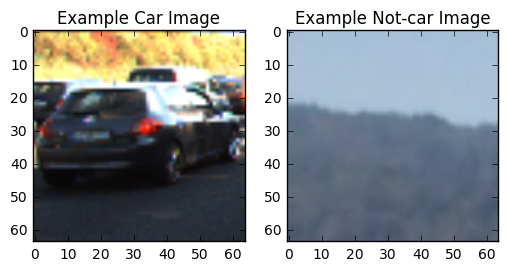

In [4]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

# Histogram of Oriented Gradients (HOG)

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

(7, 7, 2, 2, 9)


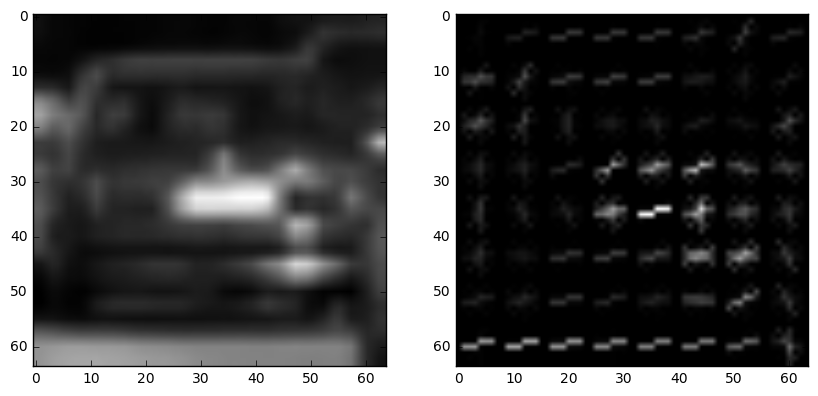

In [6]:
# HOG feature extarct params
pix_per_cell = 8
cell_per_block = 2
orient = 9

car_ind = np.random.randint(0, len(cars))
img = mpimg.imread(cars[car_ind])

# since img read is .png, array values range from 0 to 1
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
print(features.shape)



f,(ax1,ax2) =  plt.subplots(1,2,figsize=(10,20))
ax1.imshow(gray,cmap='gray')
ax2.imshow(hog_image,cmap='gray')


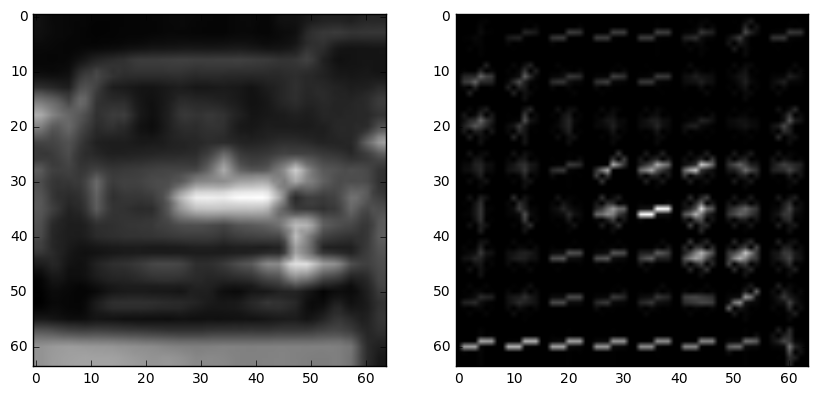

In [7]:
img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
L_channel = img_HLS[:,:,1]
features, hog_image = get_hog_features(L_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f,(ax1,ax2) =  plt.subplots(1,2,figsize=(10,20))
ax1.imshow(L_channel,cmap='gray')
ax2.imshow(hog_image,cmap='gray')

In [8]:
# combine color based and shape based features

HSV_features = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
print(HSV_features.shape)
HSV_features = HSV_features.flatten()
#HSV_features = HSV_features.reshape(64*64*3)
print(HSV_features.shape)

hog_features = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=False , feature_vec=True)
print(hog_features.shape)

(64, 64, 3)
(12288,)
(1764,)


In [9]:
combined_features = np.concatenate([HSV_features,hog_features])
print(combined_features.shape)

(14052,)


# spatial binning of color

In [10]:
def bin_spatial(img, size=(32, 32)):
    features =[]
    for channel in range(img.shape[2]) :     
        # Use cv2.resize().ravel() to create the feature vector
        features.append(cv2.resize(img[:,:,channel], size).ravel()) 
    #features = np.concatenate(features)
    features = np.ravel(features)
    # Return the feature vector
    return features

In [11]:
def bin_spatial1(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    #features = np.hstack((color1,color2,color3))
    features = np.concatenate((color1,color2,color3))
    # Return the feature vector
    return features

In [13]:
car_ind = np.random.randint(0, len(cars))
img = mpimg.imread(cars[car_ind])

spatial_features = bin_spatial(img,(32,32))
spatial_features1 = bin_spatial1(img,(32,32))

print("spatial_features {} shape {}".format(spatial_features, spatial_features.shape))
print("spatial_features1 {} shape {}".format(spatial_features1, spatial_features1.shape))

spatial_features [ 0.17843139  0.20392159  0.20686275 ...,  0.6490196   0.71274507
  0.70098042] shape (3072,)
spatial_features1 [ 0.17843139  0.20392159  0.20686275 ...,  0.6490196   0.71274507
  0.70098042] shape (3072,)


In [14]:
def color_hist(img, nbins = 32):
    features =[]
    for channel in range(img.shape[2]) :     
        # Use cv2.resize().ravel() to create the feature vector
        features.append((np.histogram(img[:,:,channel], bins = nbins))[0])
    #features = np.concatenate(features)
    features = np.ravel(features)
    # Return the feature vector
    return features

In [15]:
def color_hist1(img,nbins =32):
    channel1_hist = np.histogram(img[:,:,0] , bins = nbins)
    channel2_hist = np.histogram(img[:,:,1] , bins = nbins)
    channel3_hist = np.histogram(img[:,:,2] , bins = nbins)
    
    features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    
    return features

In [16]:
car_ind = np.random.randint(0, len(cars))
img = mpimg.imread(cars[car_ind])

hist_feature1 = color_hist1(img,32)
hist_feature = color_hist(img,32)

print(hist_feature1)
print(hist_feature)

[  98  437 1001  831  589  332  234  153  101   63   39   32   41   33    7
   12   10    7   18    7   14    5    9    9    4    1    1    1    1    0
    1    5   79  501  953  728  597  431  214  139  112   60   25   32   37
   55   30   11   11    4   11   15   10    8    6    9    6    3    1    1
    0    1    0    6   38  338  625  966  742  566  205  181   80   65   25
   35   40   52   26   13   10   10   12   12   10    8   11    7    7    2
    1    2    0    0    1    6]
[  98  437 1001  831  589  332  234  153  101   63   39   32   41   33    7
   12   10    7   18    7   14    5    9    9    4    1    1    1    1    0
    1    5   79  501  953  728  597  431  214  139  112   60   25   32   37
   55   30   11   11    4   11   15   10    8    6    9    6    3    1    1
    0    1    0    6   38  338  625  966  742  566  205  181   80   65   25
   35   40   52   26   13   10   10   12   12   10    8   11    7    7    2
    1    2    0    0    1    6]


In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32,orient=9,pix_per_cell=8, cell_per_block=2,
                    hog_channel = 0,spatial_feat = True, hist_feat = True, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        if spatial_feat == True:    
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
        
        if hog_feat  == True:
            hog_features =[]
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    # Apply get_hog_features() also with a color space option now
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                         cell_per_block, vis=False , feature_vec=True))
                #hog_features = np.concatenate(hog_features)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False , feature_vec=True)
                
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features


In [18]:
car_ind = np.random.randint(0, len(cars))
car = cars[car_ind]
car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32,hog_channel = 0, spatial_feat = True, hist_feat = True, hog_feat = True)
#notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
#                        hist_bins=32)

KeyboardInterrupt: 

In [19]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [20]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(255, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

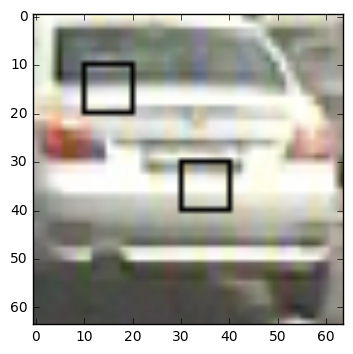

In [21]:
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((10, 10), (20, 20)), ((30, 30), (40, 40))]

car_ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[car_ind])

result = draw_boxes(image, bboxes,(255,0,0),1)
plt.imshow(result)

In [35]:
# Define a function to extract features for a single image
# Have this function call bin_spatial() and color_hist()
def single_img_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32,orient=9, 
                        pix_per_cell=8, cell_per_block=2,hog_channel = 0,spatial_feat = True, hist_feat = True, hog_feat = True,vis = True):
    # Create a list to append feature vectors to
    img_features = []
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)      
    if spatial_feat == True:    
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat  == True:
        hog_features =[]
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                # Apply get_hog_features() also with a color space option now
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                         cell_per_block, vis=False , feature_vec=True))
            #hog_features = np.concatenate(hog_features)
            hog_features = np.ravel(hog_features)
        else:
            if(vis == True):
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=True , feature_vec=True)
            else:    
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False , feature_vec=True)
        img_features.append(hog_features)       
    if vis == True:
        # Append the new feature vector to the features list
        return np.concatenate(img_features),hog_image
    else:
        # Return list of feature vectors
        return np.concatenate(img_features)


In [36]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig,rows,cols,images,titles):
    for i,img in enumerate(images):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
            

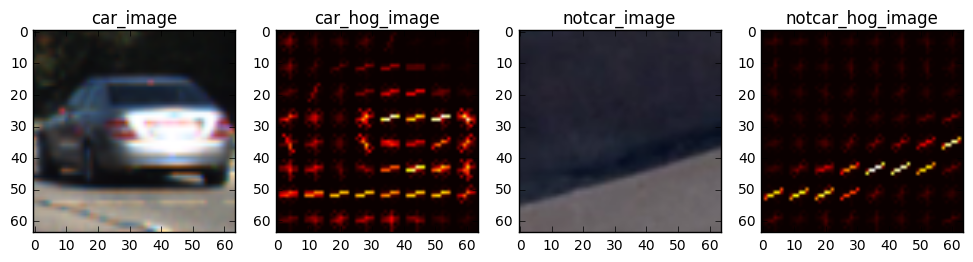

In [37]:
car_ind = np.random.randint(0, len(cars))
car = cars[car_ind]
car_image = mpimg.imread(car)

notcar_ind = np.random.randint(0, len(notcars))
notcar = notcars[notcar_ind]
notcar_image = mpimg.imread(notcar)

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


car_features,car_hog_image = single_img_features(car_image, cspace=color_space,spatial_size=spatial_size,
                        hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis = True)


notcar_features,notcar_hog_image = single_img_features(notcar_image, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis = True)


images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car_image', 'car_hog_image', 'notcar_image', 'notcar_hog_image']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)

In [ ]:
for car in cars:
    image = mpimage.imread(car)

In [ ]:
a = np.array((1,2,3))
b = np.array((2,3,4))

print(np.hstack((a,b)))

In [ ]:
a = np.array((1,2,3))
b = np.array((2,3,4))

print(np.concatenate((a,b)))

In [ ]:
a = np.array((1,2,3))
b = np.array((2,3,4))

print(np.vstack((a,b)))